# NLP OOD Detection with Score-Based Generative Models

In this notebook file, we will look into the implementation of Out-of-Distribution detection using score-based diffusion models. To understand the underlying Stochastic Differential Equation formulation, please refer to the `README.md` in doc.

In [1]:
import functools
import pathlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import ood_detectors.likelihood as likelihood
import ood_detectors.eval_utils as eval_utils
import ood_detectors.plot_utils as plot_utils
import ood_detectors.sde as sde_lib 
import ood_detectors.models as models
import ood_detectors.losses as losses
import ood_detectors.residual  as residual
from data import load_datasets

%load_ext autoreload
%autoreload 2

## 1. Pre-trained Encoders

For the empirical study, we will work on the representation space of the following text encoders:

1. `bert-base-uncased`: A base version of BERT (Bidirectional Encoder Representations from Transformers) model that is uncased, meaning it doesn't differentiate between uppercase and lowercase letters during tokenization.

2. `roberta-base`: A base version of RoBERTa (Robustly optimized BERT approach) model, which is based on BERT architecture but with improvements such as dynamic masking during pretraining and larger training data.

3. `xlm-roberta-base`: A base version of XLM-RoBERTa (Cross-lingual Language Model from RoBERTa) model, which is pre-trained on multilingual data and aims to perform well across different languages.

4. `clip`: A Contrastive Language-Image Pretraining (CLIP) model, capable of understanding text and image data in a joint embedding space, allowing it to perform various tasks, including zero-shot image classification based on text prompts.

For this tutorial, we select the representation space of `roberta-base`.

In [ ]:
encoders = ['bert-base-uncased', 'roberta-base','xlm-roberta-base', 'openai/clip-vit-base-patch32']
encoder = 'xlm-roberta-base'
device = 'cuda:1'

## 2. Datasets
For the empirical study, we will look into the following datasets:

1. `IMDB`: a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.
2. `Yelp`:  a set of 560,000 highly polar yelp reviews for training, and 38,000 for testing.
3. `SST2`: a set of 11,855 single sentences extracted from movie reviews.
4. `NC-Top-Dataset`: a set of 210k news headlines divided into 42 categories in total. `NC-Top-Dataset` contains headlines from top-7 categories. 
5. `NC-Bottom-Dataset`: a set of 210k news headlines divided into 42 categories in total. `NC-Bottom-Dataset` contains headlines from remaining categories.
6. `Amazon-Review`: a set of 1,800,000 reviews from Amazon for training samples and 200,000 for testing.
7. `Amazon-Music`: Multi domain sentiment dataset from Amazon. Reviews of the domain Music.
8. `Amazon-DVD`: Multi domain sentiment dataset from Amazon. Reviews of the domain DVD.
9. `Amazon-Camera`: Multi domain sentiment dataset from Amazon. Reviews of the domain Camera.
10. `Amazon-Books`: Multi domain sentiment dataset from Amazon. Reviews of the domain Books.
11. `Amazon-Software`: Multi domain sentiment dataset from Amazon. Reviews of the domain Software.
12. `Amazon-Health`: Multi domain sentiment dataset from Amazon. Reviews of the domain Health.

All the above datasets can be accessed via `load_datasets()` from `data.py`. `load_datasets()` provides the In-distribution and Out-of-distribution datasets depending on the following input:

1. `id`: List of datasets that are In-Distribution for the given task. Choose the dataset from the above list.
2. `ood`: List of datasets that are Out-of-Distribution for the given task. Choose the dataset from the above list.
3. `embed_model`: Embedding model used to obtain the text embeddings. ('bert-base-uncased', 'roberta-base','xlm-roberta-base', 'clip')
4. `token_len`: Number of tokens per input. 

The choice of datasets as In-Distribution and Out-of-Distribution depends on the task that you would like to perform. For this tutorial, we select `Amazon-Health` as In-distribution dataset and `Amazon-Music`, `Amazon-DVD`, `Amazon-Camera`, `Amazon-Books` and `Amazon-Software`. 


In [ ]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 KB 6.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
train_dataset, val_dataset, *ood_datasets = load_datasets(id ='Amazon-Health', 
                                                        ood=['Amazon-Music', 
                                                             'Amazon-DVD', 
                                                             'Amazon-Camera',
                                                             'Amazon-Books', 
                                                             'Amazon-Software', 
                                                            ], 
                                                        embed_model=encoder, 
                                                        device=device, token_len = 32)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


Fine-tuning the model using LoRA regularization with R=8, alpha=8, and dropout=0
trainable params: 294,912 || all params: 125,532,674 || trainable%: 0.2349


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Further, there is always an text overlap between indexes in the datasets and the size of the overlap is equal to token_len/2. However, when we jump over to the next input text, there will be a context break. The text overlap is explained with an example in the cell below:

In [ ]:
print("For the given example, we use dataset with token_len = 32 and context overlap of 16 (token_len/2) from the previous index.")
print("\n===================================================================================================================\n")
print("First Input text:", train_dataset.text[0])
print("\n===================================================================================================================\n")
print("Index 0:", train_dataset.get_text(0))
print("\n===================================================================================================================\n")
print("Index 1:", train_dataset.get_text(1))
print("\n===================================================================================================================\n")
print("Index 16:", train_dataset.get_text(16))
print("\n===================================================================================================================\n")
print(" The First input context breaks at Index 16. The index 17 starts with the first 32 tokens of the seconf input text ")
print("\n===================================================================================================================\n")
print("Index 17:", train_dataset.get_text(17))
print("\n===================================================================================================================\n")
print("Second Input text:", train_dataset.text[1])
print("\n===================================================================================================================\n")

For the given example, we use dataset with token_len = 32 and context overlap of 16 (token_len/2) from the previous index.


First Input text: to get hot lather , which is nice , you first have to get the device installed on top the can . i would not recommend this if you are easily frustrated . the directions provided are sparse in several languages . first you have to pry the top off the can of shaving cream . they provide a pry tool for that purpose which works well on some brands of shaving cream better than others . then you have to fit the device on top the can . it worked well with one brand in a large size can . when i tried it with a smaller size can of shaving cream it emptied half the can during the installation process . using a different brand in a large can , i had trouble prying the top off the can . if you have time and patience , and are willing to spend some money on various brands of shaving cream to find one that works well , give it a try . otherwise , be forewarne

Let's continue with the tutorial. We will reload the datasets again with the token_len = 512, as it is the highest limit of tokens that can be processed by `roberta-base`.

In [ ]:
train_dataset, val_dataset, *ood_datasets = load_datasets(id =['Amazon-Health', 'Amazon-Music'],
                                                        ood=[ 
                                                             'Amazon-DVD', 
                                                             'Amazon-Camera',
                                                             'Amazon-Books', 
                                                             'Amazon-Software', 
                                                            ], 
                                                        embed_model=encoder, 
                                                        device=device, token_len = 512, fine_tune = False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print("No of training data:", len(train_dataset))
print("No of validation data:", len(val_dataset))
print("No of ood data:", sum([len(d) for d in ood_datasets]))

No of training data: 3342
No of validation data: 827
No of ood data: 8817


## 3. Residual

In [ ]:
#Number of dimensions for OOD
dim = 512 
#number of  models in the ensemble
k=10

#Training parameters
n_epochs = 5000
batch_size = 1024


100%|██████████| 10/10 [00:00<00:00, 61.90it/s]


AUC: 28.64% for Amazon-Health_Amazon-Music and Amazon-Health_Amazon-Music_eval


100%|██████████| 10/10 [00:00<00:00, 19.56it/s]


AUC: 74.19% for Amazon-Health_Amazon-Music_eval and Amazon-DVD


100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


AUC: 64.69% for Amazon-Health_Amazon-Music_eval and Amazon-Camera


100%|██████████| 10/10 [00:00<00:00, 15.61it/s]


AUC: 84.10% for Amazon-Health_Amazon-Music_eval and Amazon-Books


100%|██████████| 10/10 [00:00<00:00, 16.76it/s]


AUC: 77.93% for Amazon-Health_Amazon-Music_eval and Amazon-Software
Generating plots...


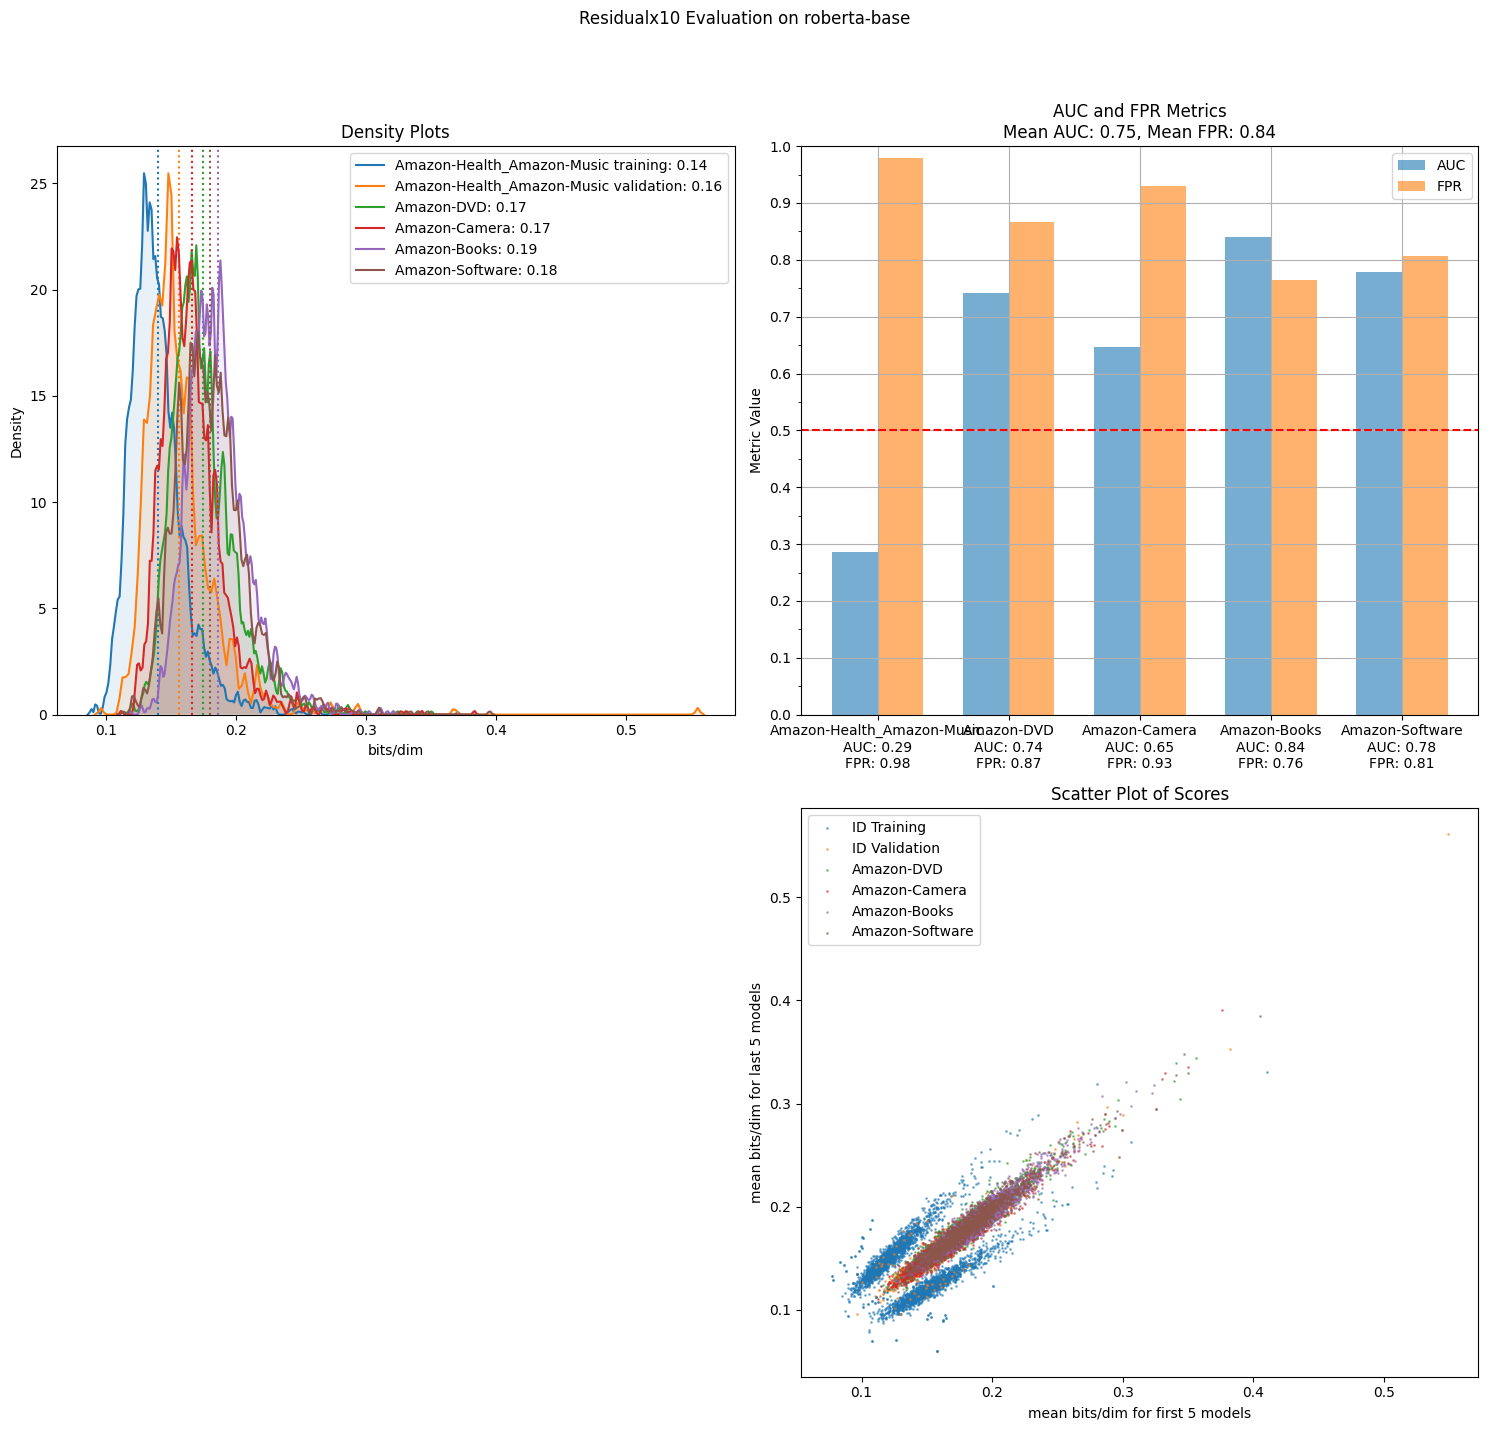

In [ ]:

#Define Residual model using ood_detectors library
model_residual = residual.ResidualX(dim, k=k)

#Train the Residual model
model_residual.fit(train_dataset)

#Get Residual score for Training and Validation data
score_id = model_residual.predict(train_dataset)
score_ref = model_residual.predict(val_dataset)
print(f"AUC: {eval_utils.auc(-score_ref, -score_id):.2%} for {train_dataset.name} and {val_dataset.name}")


#Get Residual score for OOD datasets
for ood_dataset in ood_datasets:
    score = model_residual.predict(ood_dataset)
    print(f"AUC: {eval_utils.auc(-score_ref, -score):.2%} for {val_dataset.name} and {ood_dataset.name}")

#Save the Residual model
torch.save(model_residual, 'model_residual.pth')

#Plot the results
results = eval_utils.eval_ood(model_residual, train_dataset, val_dataset, ood_datasets, batch_size, verbose=False)
plot_utils.plot(results, train_dataset.name, [od.name for od in ood_datasets], encoder=encoder, model=model_residual.name,
                train_loss=None, out_dir ='figs')

## 4. Likelihood  

### 4.1 Direct Computation of Likelihood

In [15]:
#Number of dimensions for OOD
feat_dim=train_dataset.feat_dim

#Define SDE Diffusion model using ood_detectors library
model_NLL = likelihood.RDM(feat_dim, k=k).to(device)

#Train the SDE model
train_loss = model_NLL.fit(train_dataset, n_epochs, batch_size)

score_id = model_NLL.predict(train_dataset, batch_size, verbose=False)
score_ref = model_NLL.predict(val_dataset, batch_size, verbose=False)
print(f"AUC: {eval_utils.auc(-score_ref, -score_id):.2%} for {train_dataset.name} and {val_dataset.name}")

#Get Residual score for OOD datasets
for ood_dataset in ood_datasets:
    score = model_NLL.predict(ood_dataset, batch_size, verbose=False)
    print(f"AUC: {eval_utils.auc(-score_ref, -score):.2%} for {val_dataset.name} and {ood_dataset.name}")

#Save the Likelihood model
torch.save(model_NLL.state_dict(), 'model_NLL_dc.pth')
results = eval_utils.eval_ood(model_NLL, train_dataset, val_dataset, ood_datasets, batch_size, verbose=False)


Training for 5000 epochs...


Average Loss: 0.049570: 100%|██████████| 5000/5000 [03:30<00:00, 23.74it/s]


AUC: 27.63% for Amazon-Health_Amazon-Music and Amazon-Health_Amazon-Music_eval
AUC: 72.54% for Amazon-Health_Amazon-Music_eval and Amazon-DVD
AUC: 66.20% for Amazon-Health_Amazon-Music_eval and Amazon-Camera
AUC: 84.57% for Amazon-Health_Amazon-Music_eval and Amazon-Books


Generating plots...


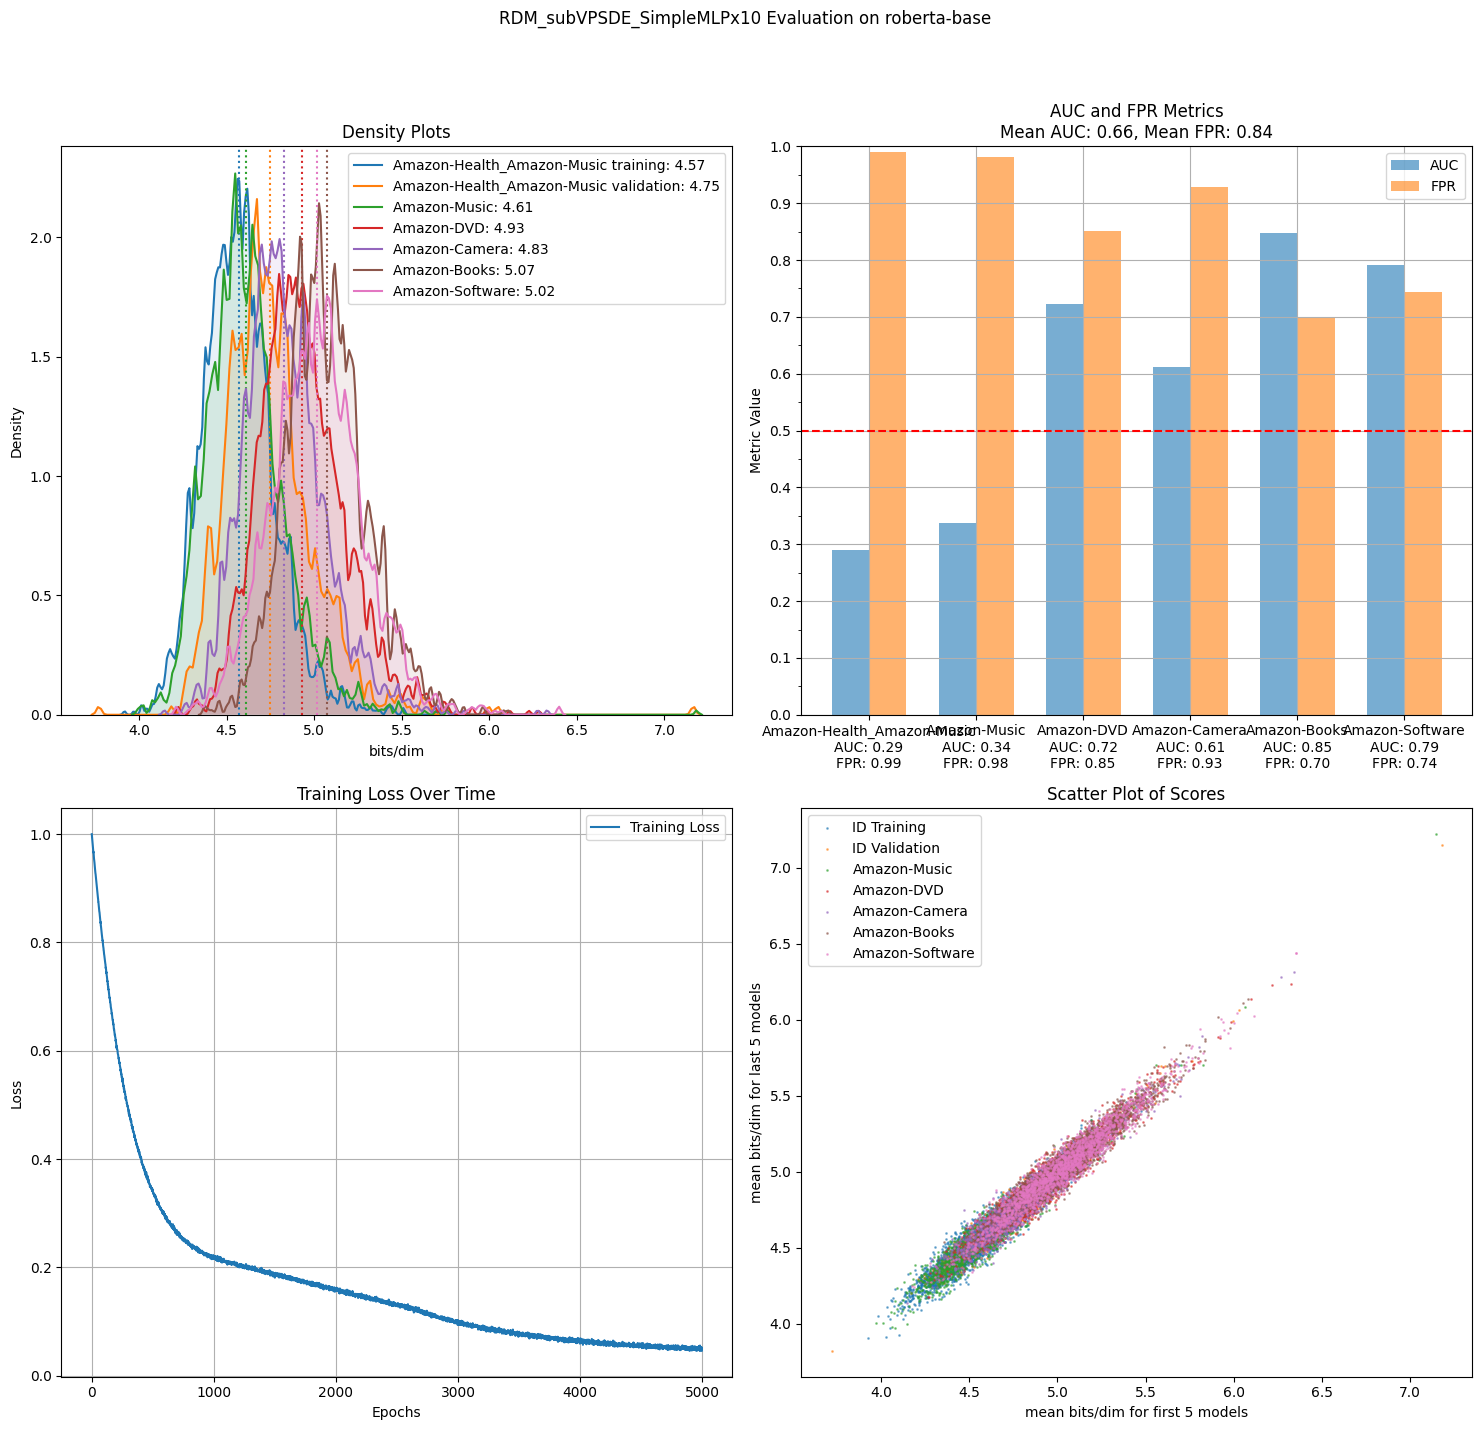

In [ ]:

#Plot the results
plot_utils.plot(results, train_dataset.name, [od.name for od in ood_datasets], encoder=encoder, model=model_NLL.name,
                train_loss=train_loss, out_dir ='figs')

### 4.2 Likelihood Computation using Hyper-parameter selection

Training for 5000 epochs...


Average Loss: 0.076254: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:12<00:00, 37.60it/s]


Generating plots...


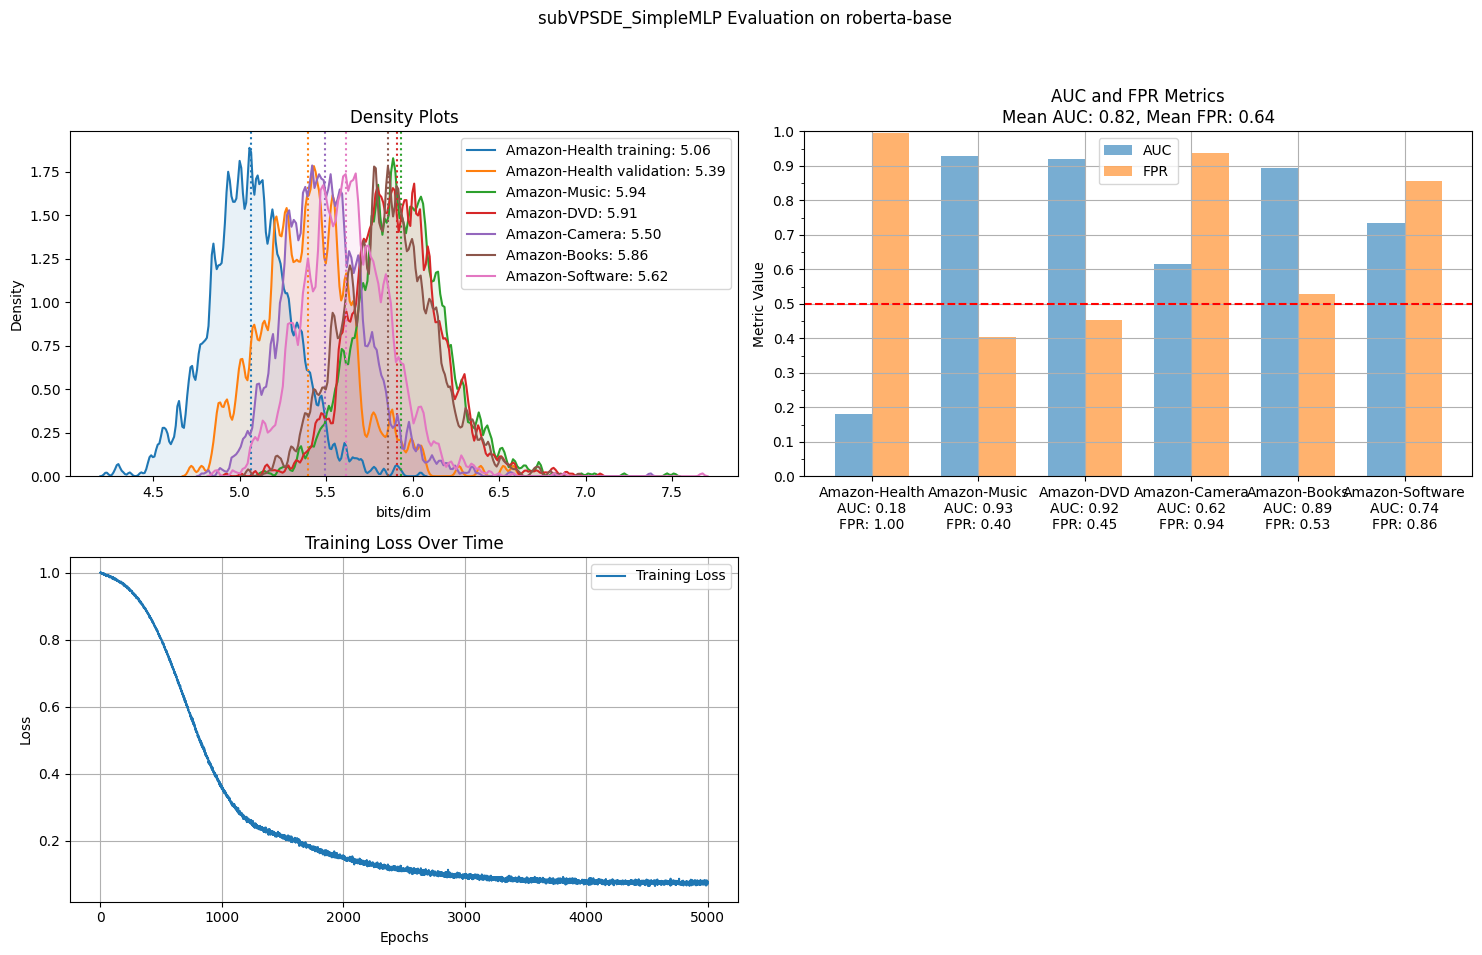

In [10]:
#Model Parameters
bottleneck_channels=512
num_res_blocks=6
time_embed_dim=256
dropout = 0.25

#Hyperparameters
lr= 0.0002
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
weight_decay = 0
warmup = 5000
grad_clip = 1
ema_rate=0.9999

#Train Parameters
continuous = True
reduce_mean = True
likelihood_weighting = False
beta_min = 0.1
beta_max = 20
sigma_min = 0.01
sigma_max = 50

#Define SDE model using ood_detectors library
sde = sde_lib.subVPSDE(beta_min=beta_min, beta_max=beta_max)

#Define the underlying MLP for SDE model using ood_detectors library
model = models.SimpleMLP(
    channels=feat_dim,
    bottleneck_channels=bottleneck_channels,
    num_res_blocks=num_res_blocks,
    time_embed_dim=time_embed_dim,
    dropout=dropout,
)

#Define the optimizer
optimizer = functools.partial(
                torch.optim.Adam,
                lr=lr,
                betas=(beta1, beta2),
                eps=eps,
                weight_decay=weight_decay,
                )

#Define the Likelihood model
ood_detector = likelihood.Likelihood(
    sde = sde,
    model = model,
    optimizer = optimizer,
    ).to(device)

update_fn = functools.partial(
    losses.SDE_LRS_BF16, 
    total_steps=len(train_dataset)//batch_size * n_epochs,
    continuous=continuous,
    reduce_mean=reduce_mean,
    likelihood_weighting=likelihood_weighting,
    )

#Train the Likelihood model
ood_train_loss = ood_detector.fit(
    train_dataset,  
    n_epochs=n_epochs,
    batch_size=batch_size,
    update_fn=update_fn,
    )

#Save the Likelihood model
torch.save(ood_detector.state_dict(), 'model_NLL_hs.pth')

#Plot the results
results = eval_utils.eval_ood(ood_detector, train_dataset, val_dataset, ood_datasets, batch_size, verbose=False)
plot_utils.plot(results, train_dataset.name, [od.name for od in ood_datasets], encoder=encoder, model=ood_detector.name,
                train_loss=ood_train_loss, out_dir ='figs')